Tunning on second run:

**Linear regression** - none. keeping this baseline

**Decision tree** - likely overfitting.
  1. max_depth = btwn 6 to 12
  2. min_samples_leaf = 5 to 10
  3. add max_features = auto, sqrt, log2
  4. min_samples_split from [10, 20, 50] to [2, 5, 10]
  5. add cross validation

**Random Forest** - best performer. Can and should still be tweaked.
  1. n_estimators from 100 to [100, 300, 500]
  2. max_depth from 200 to [10, 20, 30]
  3. add max_features = auto, sqrt
  4. min_samples_leaf from 5 to [1, 3, 5]
  5. add bootstrap: [True, False]
  6. *maybe* use RandomizedSearchCV
  7. *maybe* max_features='sqrt' + min_samples_leaf>5 to prevent overfitting

**XGBoost** - will tune
  1. n_estimators
  2. learning_rate
  3. max_depth
  4. subsample
  5. colsample_bytree
  6. reg_alpha
  7. reg_lambda
  8. *maybe* early stopping with val set

**LightGBM** - underwhelming. Going to leave this one alone for now.

**CatBoost** - fine to leave alone. The other ones are more promising.

**Neural Network** - needs severe tuning efforts.
  1. features need to be standardized
  2. more layers
  3. add dropout
  4. *maybe* use callbacks
  5. experiment with MAE
  6. log(SalePrice)
  7. if things work out for this model, then I might consider ensambling.

# Setup

In [3]:
import pandas as pd

In [4]:
test_df = pd.read_csv('test_df_MR_lite.csv')
train_df = pd.read_csv('train_df_lite_withsolution.csv')
valid_df = pd.read_csv('valid_with_solution_MR.csv')

In [5]:
test_df.columns

Index(['fiModelDescriptor_freq', 'ProductSize_Large / Medium',
       'ProductGroup_SSL', 'Ripper_Yes', 'ProductSize_Medium',
       'ProductSize_Large', 'Enclosure_EROPS w AC', 'UnemploymentRate',
       'fiSecondaryDesc_freq', 'Estimated_Hours_log'],
      dtype='object')

In [6]:
test_df.shape

(12457, 10)

In [7]:
train_df.columns

Index(['fiModelDescriptor_freq', 'ProductGroup_SSL', 'ProductSize_Large',
       'Enclosure_EROPS w AC', 'UnemploymentRate',
       'ProductSize_Large / Medium', 'SalePrice', 'fiSecondaryDesc_freq',
       'Estimated_Hours_log', 'Ripper_Yes', 'ProductSize_Medium',
       'Drive_System_Four Wheel Drive'],
      dtype='object')

In [8]:
train_df.shape

(421246, 12)

In [9]:
valid_df.columns

Index(['SalesID', 'fiModelDescriptor_freq', 'ProductSize_Large / Medium',
       'ProductGroup_SSL', 'Ripper_Yes', 'ProductSize_Medium',
       'ProductSize_Large', 'Enclosure_EROPS w AC', 'UnemploymentRate',
       'fiSecondaryDesc_freq', 'Estimated_Hours_log', 'SalePrice'],
      dtype='object')

In [10]:
valid_df.shape

(11573, 12)

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
import os
checkpoint_dir = '/content/drive/MyDrive/demand_prediction_checkpoints/'
os.makedirs(checkpoint_dir, exist_ok=True)

In [13]:
import pandas as pd
import numpy as np
import pickle
import json
from datetime import datetime
import gc
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import torch
print(f"PyTorch GPU Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")

PyTorch GPU Available: True
GPU Name: NVIDIA L4
GPU Memory: 22.16 GB


In [14]:
def calculate_metrics(y_true, y_pred, model_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    mask = y_true != 0
    mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

    return {
        'model': model_name,
        'rmse': rmse,
        'mae': mae,
        'r2': r2,
        'mape': mape
    }

def save_checkpoint(data, filename):
    filepath = os.path.join(checkpoint_dir, filename)
    with open(filepath, 'wb') as f:
        pickle.dump(data, f)
    print(f"Checkpoint saved: {filename}")

def load_checkpoint(filename):
    filepath = os.path.join(checkpoint_dir, filename)
    if os.path.exists(filepath):
        with open(filepath, 'rb') as f:
            print(f"Checkpoint loaded: {filename}")
            return pickle.load(f)
    return None

def print_metrics(metrics):
    print(f"{'='*50}")
    print(f"Model: {metrics['model']}")
    print(f"{'='*50}")
    print(f"RMSE: ${metrics['rmse']:,.2f}")
    print(f"MAE:  ${metrics['mae']:,.2f}")
    print(f"R²:   {metrics['r2']:.4f}")
    print(f"MAPE: {metrics['mape']:.2f}%")
    print(f"{'='*50}")

In [15]:
processed_data = load_checkpoint('processed_data.pkl')

if processed_data is None:
    print("Loading training data from CSV...")
    dtypes = {
        'fiModelDescriptor_freq': 'float32',
        'fiSecondaryDesc_freq': 'float32',
        'UnemploymentRate': 'float32',
        'Estimated_Hours_log': 'float32',
        'SalePrice': 'float32'
    }
    train_df = pd.read_csv('/content/train_df_MR_lite.csv', dtype=dtypes)

    print(f"Training data shape: {train_df.shape}")
    print(f"Memory usage: {train_df.memory_usage().sum() / 1024**2:.2f} MB")
    print(f"Columns: {list(train_df.columns)}")
else:
    print("Loading preprocessed data from checkpoint...")
    train_df = processed_data

Loading training data from CSV...
Training data shape: (421246, 11)
Memory usage: 10.45 MB
Columns: ['fiModelDescriptor_freq', 'ProductGroup_SSL', 'ProductSize_Large', 'Enclosure_EROPS w AC', 'UnemploymentRate', 'ProductSize_Large / Medium', 'SalePrice', 'fiSecondaryDesc_freq', 'Estimated_Hours_log', 'Ripper_Yes', 'ProductSize_Medium']


In [16]:
# --run next--
if processed_data is None:
    print(train_df.isnull().sum())
    print(f"Total missing values: {train_df.isnull().sum().sum()}")

    if train_df.isnull().sum().sum() > 0:
        numeric_cols = train_df.select_dtypes(include=[np.number]).columns
        for col in numeric_cols:
            if train_df[col].isnull().sum() > 0:
                median_value = train_df[col].median()
                train_df[col].fillna(median_value, inplace=True)
                print(f"  Filled {col} with median: {median_value}")

        print(f"Missing values after handling: {train_df.isnull().sum().sum()}")
        save_checkpoint(train_df, 'processed_data_imputed.pkl')
else:
    print("Data was loaded.")

split_data = load_checkpoint('train_test_split.pkl')

if split_data is None:
    print("Creating train-test split...")

    X = train_df.drop('SalePrice', axis=1)
    y = train_df['SalePrice']

    print(f"Features shape: {X.shape}")
    print(f"Target shape: {y.shape}")
    print(f"Target range: ${y.min():,.0f} - ${y.max():,.0f}")

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    print(f"Train set: {X_train.shape}")
    print(f"Test set: {X_test.shape}")

    save_checkpoint({
        'X_train': X_train, 'X_test': X_test,
        'y_train': y_train, 'y_test': y_test,
        'feature_names': list(X.columns)
    }, 'train_test_split.pkl')

    # Free memory
    del train_df
    gc.collect()
else:
    X_train = split_data['X_train']
    X_test = split_data['X_test']
    y_train = split_data['y_train']
    y_test = split_data['y_test']
    print(f"Train set: {X_train.shape}")
    print(f"Test set: {X_test.shape}")

fiModelDescriptor_freq        1
ProductGroup_SSL              0
ProductSize_Large             0
Enclosure_EROPS w AC          0
UnemploymentRate              1
ProductSize_Large / Medium    0
SalePrice                     0
fiSecondaryDesc_freq          1
Estimated_Hours_log           4
Ripper_Yes                    0
ProductSize_Medium            0
dtype: int64
Total missing values: 7
  Filled fiModelDescriptor_freq with median: 329206.0
  Filled UnemploymentRate with median: 5.599999904632568
  Filled fiSecondaryDesc_freq with median: 39251.0
  Filled Estimated_Hours_log with median: 0.0
Missing values after handling: 0
Checkpoint saved: processed_data_imputed.pkl
Creating train-test split...
Features shape: (421246, 10)
Target shape: (421246,)
Target range: $4,750 - $142,000
Train set: (336996, 10)
Test set: (84250, 10)
Checkpoint saved: train_test_split.pkl


In [17]:
# --run next and continue-- Checking for existing scaler (better safe than sorry)
scaler_data = load_checkpoint('scaler_data.pkl')

split_data = load_checkpoint('train_test_split.pkl')
X_train = split_data['X_train']
X_test = split_data['X_test']
y_train = split_data['y_train']

if scaler_data is None:
    print("Scaling features...")

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    print(f"Scaled train shape: {X_train_scaled.shape}")
    print(f"Scaled test shape: {X_test_scaled.shape}")

    save_checkpoint({
        'scaler': scaler,
        'X_train_scaled': X_train_scaled,
        'X_test_scaled': X_test_scaled
    }, 'scaler_data.pkl')
else:
    scaler = scaler_data['scaler']
    X_train_scaled = scaler_data['X_train_scaled']
    X_test_scaled = scaler_data['X_test_scaled']

print(f"NaN in X_train_scaled: {np.isnan(X_train_scaled).sum()}")
print(f"NaN in X_test_scaled: {np.isnan(X_test_scaled).sum()}")

Checkpoint loaded: train_test_split.pkl
Scaling features...
Scaled train shape: (336996, 10)
Scaled test shape: (84250, 10)
Checkpoint saved: scaler_data.pkl
NaN in X_train_scaled: 0
NaN in X_test_scaled: 0


In [18]:
results_df = load_checkpoint('model_results.pkl')

if results_df is None:
    results_df = pd.DataFrame(columns=['model', 'rmse', 'mae', 'r2', 'mape', 'timestamp'])
    print("Created new results tracking DataFrame")
else:
    print(f"Loaded existing results with {len(results_df)} models")
    print("Existing models:")
    for idx, row in results_df.iterrows():
        print(f"  - {row['model']}: RMSE=${row['rmse']:,.2f}, R²={row['r2']:.4f}")

Created new results tracking DataFrame


In [19]:
results_df = load_checkpoint('model_results.pkl')

if results_df is None:
    results_df = pd.DataFrame(columns=['model', 'rmse', 'mae', 'r2', 'mape', 'timestamp'])
else:
    print(f"Loaded existing results with {len(results_df)} models")
    print("Existing models:")
    for idx, row in results_df.iterrows():
        print(f"  - {row['model']}: RMSE=${row['rmse']:,.2f}, R²={row['r2']:.4f}")

# Baseline Models

## Linear Regression

In [ ]:
lr_checkpoint = load_checkpoint('linear_regression.pkl')

if lr_checkpoint is None:
    print("Training Linear Regression...")
    from sklearn.linear_model import LinearRegression

    lr_model = LinearRegression()
    lr_model.fit(X_train_scaled, y_train)

    save_checkpoint({'model': lr_model}, 'linear_regression.pkl')
else:
    lr_model = lr_checkpoint['model']
    print("Loaded Linear Regression from checkpoint")

Training Linear Regression...
Checkpoint saved: linear_regression.pkl


In [ ]:
lr_pred = lr_model.predict(X_test_scaled)
print(f"Predictions shape: {lr_pred.shape}")
print(f"Prediction range: ${lr_pred.min():,.0f} - ${lr_pred.max():,.0f}")

Predictions shape: (84250,)
Prediction range: $762 - $92,143


In [ ]:
# Check for NaN values in scaled data
print("Checking for NaN values in scaled data...")
print(f"NaN in X_train_scaled: {np.isnan(X_train_scaled).sum()}")
print(f"NaN in X_test_scaled: {np.isnan(X_test_scaled).sum()}")

# If there are NaN values, we need to re-scale the data
if np.isnan(X_train_scaled).sum() > 0 or np.isnan(X_test_scaled).sum() > 0:
    print("\nRe-scaling data after handling missing values...")

    # Delete the old scaler checkpoint
    import os
    scaler_path = os.path.join(checkpoint_dir, 'scaler_data.pkl')
    if os.path.exists(scaler_path):
        os.remove(scaler_path)
        print("Removed old scaler checkpoint")

    # Reload the cleaned data
    split_data = load_checkpoint('train_test_split.pkl')
    X_train = split_data['X_train']
    X_test = split_data['X_test']

    # Check for any remaining NaN values
    print(f"\nNaN in X_train before scaling: {X_train.isnull().sum().sum()}")
    print(f"NaN in X_test before scaling: {X_test.isnull().sum().sum()}")

    # Create new scaler and scale the data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Verify no NaN values after scaling
    print(f"\nAfter re-scaling:")
    print(f"NaN in X_train_scaled: {np.isnan(X_train_scaled).sum()}")
    print(f"NaN in X_test_scaled: {np.isnan(X_test_scaled).sum()}")

    # Save the new scaler and scaled data
    save_checkpoint({
        'scaler': scaler,
        'X_train_scaled': X_train_scaled,
        'X_test_scaled': X_test_scaled
    }, 'scaler_data.pkl')

    print("\nScaling completed successfully!")

Checking for NaN values in scaled data...
NaN in X_train_scaled: 0
NaN in X_test_scaled: 0


In [ ]:
lr_metrics = calculate_metrics(y_test, lr_pred, 'Linear Regression')
print_metrics(lr_metrics)

results_df = pd.concat([results_df, pd.DataFrame([{**lr_metrics, 'timestamp': datetime.now()}])], ignore_index=True)
save_checkpoint(results_df, 'model_results.pkl')

del lr_model, lr_pred
gc.collect()

Model: Linear Regression
RMSE: $16,470.23
MAE:  $11,863.15
R²:   0.4423
MAPE: 49.75%
Checkpoint saved: model_results.pkl


27

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    'max_depth': [5, 10, 15, 20, 25],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 3, 5, 10],
    'max_features': ['sqrt', 'log2', None],
    'criterion': ['squared_error', 'friedman_mse']
}

dt = DecisionTreeRegressor(random_state=42)
search_dt = RandomizedSearchCV(
    estimator=dt,
    param_distributions=param_dist,
    n_iter=50,
    cv=5,
    scoring='neg_root_mean_squared_error',
    verbose=2,
    random_state=42,
    n_jobs=-1
)

search_dt.fit(X_train, y_train)
best_dt = search_dt.best_estimator_
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_pred = best_dt.predict(X_valid)
rmse = mean_squared_error(y_valid, y_pred, squared=False)
mae = mean_absolute_error(y_valid, y_pred)
r2 = r2_score(y_valid, y_pred)
mape = (abs((y_valid - y_pred) / y_valid).mean()) * 100

print(f" Tuned Decision Tree Results:")
print(f"RMSE: ${rmse:,.2f}")
print(f"MAE:  ${mae:,.2f}")
print(f"R²:   {r2:.4f}")
print(f"MAPE: {mape:.2f}%")

Fitting 5 folds for each of 50 candidates, totalling 250 fits


NameError: name 'X_valid' is not defined

## Decision Tree

In [ ]:
dt_checkpoint = load_checkpoint('decision_tree.pkl')

if dt_checkpoint is None:
    print("Training Decision Tree with hyperparameter tuning...")
    from sklearn.tree import DecisionTreeRegressor

    param_grid = {
        'max_depth': [10, 20, 30],
        'min_samples_split': [10, 20, 50],
        'min_samples_leaf': [5, 10, 20]
    }

    dt_model = DecisionTreeRegressor(random_state=42)
    dt_grid = GridSearchCV(dt_model, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)

    print("Running grid search...")
    dt_grid.fit(X_train, y_train)

    print(f"Best parameters: {dt_grid.best_params_}")

    save_checkpoint({
        'model': dt_grid.best_estimator_,
        'best_params': dt_grid.best_params_,
        'cv_results': dt_grid.cv_results_
    }, 'decision_tree.pkl')

    dt_model = dt_grid.best_estimator_
else:
    dt_model = dt_checkpoint['model']
    print(f"Loaded Decision Tree from checkpoint")
    print(f"Best parameters: {dt_checkpoint['best_params']}")

Checkpoint loaded: decision_tree.pkl
Loaded Decision Tree from checkpoint
Best parameters: {'max_depth': 20, 'min_samples_leaf': 10, 'min_samples_split': 10}


In [ ]:
dt_pred = dt_model.predict(X_test)
dt_pred.shape

(84250,)

In [ ]:
dt_metrics = calculate_metrics(y_test, dt_pred, 'Decision Tree')
print_metrics(dt_metrics)

results_df = pd.concat([results_df, pd.DataFrame([{**dt_metrics, 'timestamp': datetime.now()}])], ignore_index=True)
save_checkpoint(results_df, 'model_results.pkl')

del dt_model, dt_pred
gc.collect()

Model: Decision Tree
RMSE: $12,545.07
MAE:  $8,508.08
R²:   0.6764
MAPE: 33.88%
Checkpoint saved: model_results.pkl


0

In [20]:
from sklearn.tree import DecisionTreeRegressor

print("Tuning Decision Tree to reduce overfitting...")

# New parameter grid per instructions
dt_param_grid = {
    'max_depth': [6, 8, 10, 12],  # Reduced from [10, 20, 30]
    'min_samples_split': [2, 5, 10],  # Reduced from [10, 20, 50]
    'min_samples_leaf': [5, 7, 10],  # Adjusted from [5, 10, 20]
    'max_features': ['auto', 'sqrt', 'log2']  # Added
}

dt_model = DecisionTreeRegressor(random_state=42)

# Use GridSearchCV with cross-validation
dt_grid = GridSearchCV(
    dt_model,
    dt_param_grid,
    cv=5,  # 5-fold cross-validation
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

print("Running grid search with cross-validation...")
dt_grid.fit(X_train, y_train)

print(f"Best parameters: {dt_grid.best_params_}")
print(f"Best CV score: {np.sqrt(-dt_grid.best_score_):,.2f}")
dt_pred = dt_grid.best_estimator_.predict(X_test)
dt_metrics = calculate_metrics(y_test, dt_pred, 'Decision Tree (Tuned)')
print_metrics(dt_metrics)

results_df = pd.concat([results_df, pd.DataFrame([{
    **dt_metrics,
    'timestamp': datetime.now(),
    'params': json.dumps(dt_grid.best_params_)
}])], ignore_index=True)

save_checkpoint(results_df, 'model_results_tuned.pkl')
save_checkpoint({
    'model': dt_grid.best_estimator_,
    'best_params': dt_grid.best_params_,
    'cv_results': dt_grid.cv_results_
}, 'decision_tree_tuned.pkl')

Tuning Decision Tree to reduce overfitting...
Running grid search with cross-validation...
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters: {'max_depth': 12, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 2}
Best CV score: 14,492.54
Model: Decision Tree (Tuned)
RMSE: $14,721.90
MAE:  $10,243.28
R²:   0.5544
MAPE: 41.63%
Checkpoint saved: model_results_tuned.pkl
Checkpoint saved: decision_tree_tuned.pkl


The results indicate that the first decision tree run was clearly overfitting. With this tuned version, it isn't memorizing as much but at the cost of accuracy; however, it has less variance so i would consider this version more stable.

## Random Forest

In [ ]:
rf_checkpoint = load_checkpoint('random_forest.pkl')

if rf_checkpoint is None:
    print("Training Random Forest...")
    from sklearn.ensemble import RandomForestRegressor

    rf_model = RandomForestRegressor(
        n_estimators=100,
        max_depth=20,
        min_samples_split=10,
        min_samples_leaf=5,
        random_state=42,
        n_jobs=-1
    )

    rf_model.fit(X_train, y_train)

    save_checkpoint({'model': rf_model}, 'random_forest.pkl')
else:
    rf_model = rf_checkpoint['model']
    print("Loaded Random Forest from checkpoint")

Checkpoint loaded: random_forest.pkl
Loaded Random Forest from checkpoint


In [ ]:
rf_pred = rf_model.predict(X_test)
rf_pred.shape

(84250,)

In [ ]:
rf_metrics = calculate_metrics(y_test, rf_pred, 'Random Forest')
print_metrics(rf_metrics)

# Feature importance
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 5 Important Features:")
print(feature_importance.head())

results_df = pd.concat([results_df, pd.DataFrame([{**rf_metrics, 'timestamp': datetime.now()}])], ignore_index=True)
save_checkpoint(results_df, 'model_results.pkl')

del rf_model, rf_pred
gc.collect()

Model: Random Forest
RMSE: $12,261.98
MAE:  $8,322.52
R²:   0.6909
MAPE: 33.31%
Top 5 Important Features:
                  feature  importance
3    Enclosure_EROPS w AC    0.275235
6    fiSecondaryDesc_freq    0.238333
4        UnemploymentRate    0.093456
7     Estimated_Hours_log    0.083271
0  fiModelDescriptor_freq    0.078357
Checkpoint saved: model_results.pkl


46

In [21]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
# Tuned

# Expanded parameter distributions
rf_param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],  # Expanded from just 100
    'max_depth': [10, 15, 20, 25, 30, None],  # Adjusted from 200(?)
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 3, 4, 5],  # Reduced from [5]
    'max_features': ['auto', 'sqrt'],  # Added
    'bootstrap': [True, False]  # Added
}

rf_model = RandomForestRegressor(random_state=42, n_jobs=-1)

# Use RandomizedSearchCV for efficiency
rf_random = RandomizedSearchCV(
    rf_model,
    rf_param_dist,
    n_iter=50,  # Number of parameter settings sampled
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

print("Running randomized search...")
rf_random.fit(X_train, y_train)

print(f"Best parameters: {rf_random.best_params_}")
print(f"Best CV score: {np.sqrt(-rf_random.best_score_):,.2f}")

rf_pred = rf_random.best_estimator_.predict(X_test)

rf_metrics = calculate_metrics(y_test, rf_pred, 'Random Forest (Tuned)')
print_metrics(rf_metrics)

feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_random.best_estimator_.feature_importances_
}).sort_values('importance', ascending=False)

results_df = pd.concat([results_df, pd.DataFrame([{
    **rf_metrics,
    'timestamp': datetime.now(),
    'params': json.dumps(rf_random.best_params_)
}])], ignore_index=True)

save_checkpoint(results_df, 'model_results_tuned.pkl')
save_checkpoint({
    'model': rf_random.best_estimator_,
    'best_params': rf_random.best_params_,
    'cv_results': rf_random.cv_results_
}, 'random_forest_tuned.pkl')

Running randomized search...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 30, 'bootstrap': False}
Best CV score: 12,290.66
Model: Random Forest (Tuned)
RMSE: $12,182.78
MAE:  $8,201.54
R²:   0.6948
MAPE: 32.97%
Checkpoint saved: model_results_tuned.pkl
Checkpoint saved: random_forest_tuned.pkl


# Advanced Models

## XGBoost

In [ ]:
# --do not run--
# model updated
xgb_checkpoint = load_checkpoint('xgboost.pkl')

if xgb_checkpoint is None:
    print("Training XGBoost with GPU...")
    import xgboost as xgb
    import torch
    gpu_available = torch.cuda.is_available()

    xgb_params = {
        'tree_method': 'gpu_hist' if gpu_available else 'hist',
        'gpu_id': 0 if gpu_available else None,
        'max_depth': 10,
        'learning_rate': 0.1,
        'n_estimators': 100,
        'objective': 'reg:squarederror',
        'random_state': 42,
    }

    xgb_params = {k: v for k, v in xgb_params.items() if v is not None}
    print(f"Using {'GPU' if gpu_available else 'CPU'} for training")

    xgb_model = xgb.XGBRegressor(**xgb_params)

    xgb_model.fit(
        X_train, y_train,
        eval_set=[(X_test, y_test)],
        verbose=True
    )

    best_iter = None
    if hasattr(xgb_model, 'best_iteration'):
        best_iter = xgb_model.best_iteration
        print(f"Best iteration: {best_iter}")
    else:
        print(f"Trained for {xgb_model.n_estimators} iterations (no early stopping callbacks specified)")


    save_checkpoint({
        'model': xgb_model,
        'params': xgb_params,
        'best_iteration': best_iter # This might be None
    }, 'xgboost.pkl')
else:
    import xgboost as xgb
    xgb_model = xgb_checkpoint['model']
    print(f"Loaded XGBoost from checkpoint (best iteration: {xgb_checkpoint.get('best_iteration', 'N/A')})")

Training XGBoost with GPU...
Using GPU for training
[0]	validation_0-rmse:20701.01457
[1]	validation_0-rmse:19534.11546
[2]	validation_0-rmse:18540.69137
[3]	validation_0-rmse:17694.98160
[4]	validation_0-rmse:16971.34938
[5]	validation_0-rmse:16358.00403
[6]	validation_0-rmse:15824.02202
[7]	validation_0-rmse:15379.43633
[8]	validation_0-rmse:14993.61039
[9]	validation_0-rmse:14671.32443
[10]	validation_0-rmse:14396.05122
[11]	validation_0-rmse:14162.49557
[12]	validation_0-rmse:13960.50707
[13]	validation_0-rmse:13800.10765
[14]	validation_0-rmse:13652.53331
[15]	validation_0-rmse:13525.43155
[16]	validation_0-rmse:13408.51841
[17]	validation_0-rmse:13311.12589
[18]	validation_0-rmse:13234.91860
[19]	validation_0-rmse:13160.26888
[20]	validation_0-rmse:13090.10332
[21]	validation_0-rmse:13035.90565
[22]	validation_0-rmse:12983.47115
[23]	validation_0-rmse:12944.85862
[24]	validation_0-rmse:12900.16835
[25]	validation_0-rmse:12870.70169
[26]	validation_0-rmse:12843.95213
[27]	validati

In [ ]:
xgb_pred = xgb_model.predict(X_test)
print(f"Predictions shape: {xgb_pred.shape}")

Predictions shape: (84250,)


In [ ]:
xgb_metrics = calculate_metrics(y_test, xgb_pred, 'XGBoost')
print_metrics(xgb_metrics)

results_df = pd.concat([results_df, pd.DataFrame([{**xgb_metrics, 'timestamp': datetime.now()}])], ignore_index=True)
save_checkpoint(results_df, 'model_results.pkl')

del xgb_model, xgb_pred
gc.collect()

Model: XGBoost
RMSE: $12,280.46
MAE:  $8,413.97
R²:   0.6899
MAPE: 33.97%
Checkpoint saved: model_results.pkl


85

In [24]:
# full hypertune

!pip install xgboost
import xgboost as xgb

gpu_available = torch.cuda.is_available()

# Comprehensive parameter grid
xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [6, 8, 10, 12],
    'learning_rate': [0.01, 0.05, 0.1, 0.15],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.1, 0.5, 1.0],  # L1 regularization
    'reg_lambda': [0, 0.1, 0.5, 1.0],  # L2 regularization
}

base_params = {
    'tree_method': 'gpu_hist' if gpu_available else 'hist',
    'objective': 'reg:squarederror',
    'random_state': 42,
    'eval_metric': 'rmse'
}

if gpu_available:
    base_params['gpu_id'] = 0

xgb_model = xgb.XGBRegressor(**base_params)

xgb_random = RandomizedSearchCV(
    xgb_model,
    xgb_param_grid,
    n_iter=50,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

print(f"Using {'GPU' if gpu_available else 'CPU'} for training")
print("Running randomized search...")
xgb_random.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=True
)

print(f"Best parameters: {xgb_random.best_params_}")
print(f"Best CV score: {np.sqrt(-xgb_random.best_score_):,.2f}")

xgb_pred = xgb_random.best_estimator_.predict(X_test)
xgb_metrics = calculate_metrics(y_test, xgb_pred, 'XGBoost (Tuned)')
print_metrics(xgb_metrics)

results_df = pd.concat([results_df, pd.DataFrame([{
    **xgb_metrics,
    'timestamp': datetime.now(),
    'params': json.dumps(xgb_random.best_params_)
}])], ignore_index=True)

save_checkpoint(results_df, 'model_results_tuned.pkl')
save_checkpoint({
    'model': xgb_random.best_estimator_,
    'best_params': xgb_random.best_params_,
    'cv_results': xgb_random.cv_results_
}, 'xgboost_tuned.pkl')

Using GPU for training
Running randomized search...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
[0]	validation_0-rmse:21376.77607
[1]	validation_0-rmse:20742.53202
[2]	validation_0-rmse:20150.74006
[3]	validation_0-rmse:19593.21246
[4]	validation_0-rmse:19065.95864
[5]	validation_0-rmse:18687.00397
[6]	validation_0-rmse:18247.87316
[7]	validation_0-rmse:17947.88981
[8]	validation_0-rmse:17561.52769
[9]	validation_0-rmse:17174.71640
[10]	validation_0-rmse:16796.35848
[11]	validation_0-rmse:16572.42904
[12]	validation_0-rmse:16255.08523
[13]	validation_0-rmse:15951.94446
[14]	validation_0-rmse:15673.53325
[15]	validation_0-rmse:15426.64077
[16]	validation_0-rmse:15204.97066
[17]	validation_0-rmse:14978.83987
[18]	validation_0-rmse:14826.46177
[19]	validation_0-rmse:14693.85025
[20]	validation_0-rmse:14517.66570
[21]	validation_0-rmse:14359.27988
[22]	validation_0-rmse:14204.77756
[23]	validation_0-rmse:14060.50201
[24]	validation_0-rmse:13922.65265
[25]	validation_0-rms

In [29]:
xgb_tuned_checkpoint = load_checkpoint('xgboost_tuned.pkl')

if xgb_tuned_checkpoint is not None:
    xgb_tuned_model = xgb_tuned_checkpoint['model']
    xgb_tuned_pred = xgb_tuned_model.predict(X_test)
    predictions_df = pd.DataFrame({'Actual': y_test, 'Predicted': xgb_tuned_pred})
    csv_filename = 'xgboost_tuned_predictions.csv'
    csv_filepath = os.path.join(checkpoint_dir, csv_filename)
    predictions_df.to_csv(csv_filepath, index=False)

    print(f"Tuned XGBoost predictions saved to {csv_filepath}")
else:
    print("Tuned XGBoost model not found in checkpoint. Cannot save predictions.")

del xgb_tuned_model, xgb_tuned_pred, predictions_df
gc.collect()

Checkpoint loaded: xgboost_tuned.pkl
Tuned XGBoost predictions saved to /content/drive/MyDrive/demand_prediction_checkpoints/xgboost_tuned_predictions.csv


225

Checkpoint loaded: xgboost_tuned.pkl
Feature Importance (XGBoost Tuned):
                      feature  importance
3        Enclosure_EROPS w AC    0.240028
1            ProductGroup_SSL    0.234062
8                  Ripper_Yes    0.125732
9          ProductSize_Medium    0.123399
2           ProductSize_Large    0.099839
5  ProductSize_Large / Medium    0.074344
6        fiSecondaryDesc_freq    0.058329
0      fiModelDescriptor_freq    0.025277
7         Estimated_Hours_log    0.010622
4            UnemploymentRate    0.008368


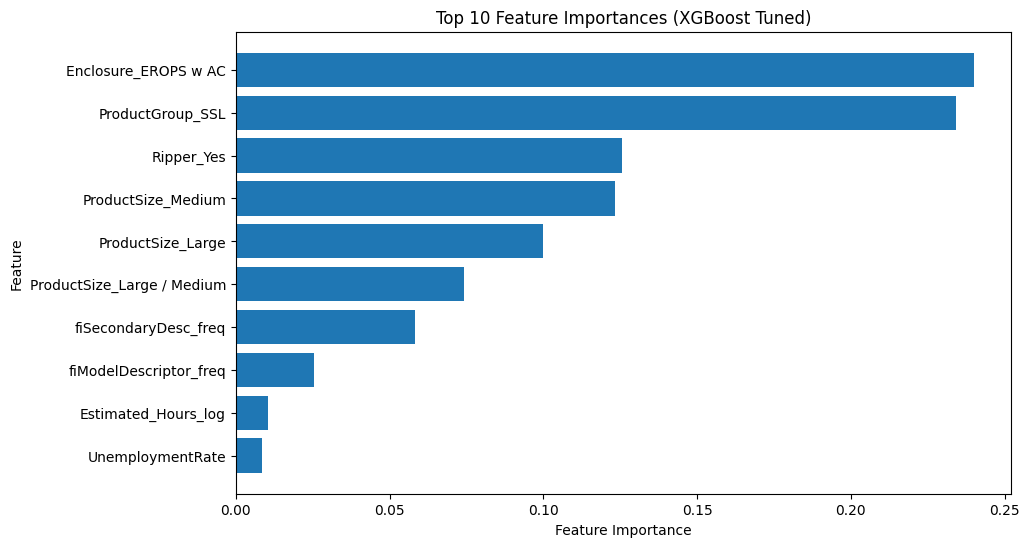

In [30]:
xgb_tuned_checkpoint = load_checkpoint('xgboost_tuned.pkl')

if xgb_tuned_checkpoint is not None:
    xgb_tuned_model = xgb_tuned_checkpoint['model']
    feature_importance = pd.DataFrame({
        'feature': X_train.columns,
        'importance': xgb_tuned_model.feature_importances_
    }).sort_values('importance', ascending=False)

    print("Feature Importance (XGBoost Tuned):")
    print(feature_importance)
    import matplotlib.pyplot as plt

    N = 10
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance['feature'][:N], feature_importance['importance'][:N])
    plt.xlabel("Feature Importance")
    plt.ylabel("Feature")
    plt.title(f"Top {N} Feature Importances (XGBoost Tuned)")
    plt.gca().invert_yaxis()
    plt.show()

else:
    print("Tuned XGBoost model not found in checkpoint. Cannot display feature importance.")

In [ ]:
train_df = pd.read_csv('train_df_48_full.csv', low_memory=False)

In [31]:
plt.figure(figsize=(10, 6))
plt.scatter(train_df['Estimated_Hours_log'], train_df['SalePrice'], alpha=0.5)
plt.xlabel('Estimated Hours (log scale)')
plt.ylabel('Sale Price')
plt.title('Sale Price vs. Estimated Hours (Log Scale)')
plt.grid(True)
plt.show()

NameError: name 'train_df' is not defined

<Figure size 1000x600 with 0 Axes>

## LightGBM

In [ ]:
import lightgbm as lgb

lgb_checkpoint = load_checkpoint('lightgbm.pkl')

if lgb_checkpoint is None:
    print("Training LightGBM...")
    lgb_params = {
        'device': 'cpu',  # Forceing CPU mode for Colab compatibility
        'objective': 'regression',
        'metric': 'rmse',
        'num_leaves': 31,
        'learning_rate': 0.05,
        'feature_fraction': 0.9,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'verbose': -1,
        'random_state': 42,
        'num_threads': -1  # Using all available CPU threads
    }
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_valid = lgb.Dataset(X_test, y_test)

    lgb_model = lgb.train(
        lgb_params,
        lgb_train,
        valid_sets=[lgb_valid],
        num_boost_round=1000,
        callbacks=[lgb.early_stopping(10), lgb.log_evaluation(0)]
    )

    print(f"Best iteration: {lgb_model.best_iteration}")

    save_checkpoint({
        'model': lgb_model,
        'params': lgb_params,
        'best_iteration': lgb_model.best_iteration
    }, 'lightgbm.pkl')
else:
    import lightgbm as lgb
    lgb_model = lgb_checkpoint['model']
    print(f"Loaded LightGBM from checkpoint (best iteration: {lgb_checkpoint.get('best_iteration', 'N/A')})")

Training LightGBM...
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 12445.5
Best iteration: 1000
Checkpoint saved: lightgbm.pkl


In [ ]:
lgb_pred = lgb_model.predict(X_test, num_iteration=lgb_model.best_iteration)
print(f"Predictions shape: {lgb_pred.shape}")

Predictions shape: (84250,)


In [ ]:
lgb_metrics = calculate_metrics(y_test, lgb_pred, 'LightGBM')
print_metrics(lgb_metrics)

results_df = pd.concat([results_df, pd.DataFrame([{**lgb_metrics, 'timestamp': datetime.now()}])], ignore_index=True)
save_checkpoint(results_df, 'model_results.pkl')

del lgb_model, lgb_pred
gc.collect()

Model: LightGBM
RMSE: $12,445.48
MAE:  $8,601.73
R²:   0.6815
MAPE: 34.89%
Checkpoint saved: model_results.pkl


3087

## CatBoost

In [ ]:
cb_checkpoint = load_checkpoint('catboost.pkl')
from catboost import CatBoostRegressor

if cb_checkpoint is None:
    print("Training CatBoost with GPU...")
    gpu_available = torch.cuda.is_available()

    cb_params = {
        'iterations': 1000,
        'learning_rate': 0.1,
        'depth': 10,
        'loss_function': 'RMSE',
        'random_state': 42,
        'verbose': False
    }
    if gpu_available:
        cb_params.update({
            'task_type': 'GPU',
            'devices': '0'
        })
    cb_model = CatBoostRegressor(**cb_params)
    cb_model.fit(
        X_train, y_train,
        eval_set=(X_test, y_test),
        early_stopping_rounds=10,
        verbose=False
    )

    print(f"Best iteration: {cb_model.best_iteration_}")

    save_checkpoint({
        'model': cb_model,
        'params': cb_params,
        'best_iteration': cb_model.best_iteration_
    }, 'catboost.pkl')
else:
    from catboost import CatBoostRegressor
    cb_model = cb_checkpoint['model']
    print(f"Loaded CatBoost from checkpoint (best iteration: {cb_checkpoint.get('best_iteration', 'N/A')})")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 22.6 MB/s eta 0:00:00
Training CatBoost with GPU...
Best iteration: 999
Checkpoint saved: catboost.pkl


In [ ]:
cb_pred = cb_model.predict(X_test)
print(f"Predictions shape: {cb_pred.shape}")

Predictions shape: (84250,)


In [ ]:
cb_metrics = calculate_metrics(y_test, cb_pred, 'CatBoost')
print_metrics(cb_metrics)

results_df = pd.concat([results_df, pd.DataFrame([{**cb_metrics, 'timestamp': datetime.now()}])], ignore_index=True)
save_checkpoint(results_df, 'model_results.pkl')

del cb_model, cb_pred
gc.collect()

Model: CatBoost
RMSE: $12,297.45
MAE:  $8,462.33
R²:   0.6891
MAPE: 34.28%
Checkpoint saved: model_results.pkl


0

# Neural Network

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
class DemandNN(nn.Module):
    def __init__(self, input_size):
        super(DemandNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [ ]:
nn_checkpoint = load_checkpoint('neural_network.pkl')

if nn_checkpoint is None:
    print("Training Neural Network on GPU...")
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    X_train_tensor = torch.FloatTensor(X_train_scaled)
    y_train_tensor = torch.FloatTensor(y_train.values).reshape(-1, 1)
    X_test_tensor = torch.FloatTensor(X_test_scaled)
    y_test_tensor = torch.FloatTensor(y_test.values).reshape(-1, 1)
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)

    model = DemandNN(X_train_scaled.shape[1]).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5)
    best_loss = float('inf')
    patience = 10
    counter = 0
    train_losses = []
    val_losses = []

    print("Training...")
    for epoch in range(100):
        model.train()
        epoch_loss = 0
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        avg_train_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        model.eval()
        with torch.no_grad():
            X_test_device = X_test_tensor.to(device)
            y_test_device = y_test_tensor.to(device)
            val_outputs = model(X_test_device)
            val_loss = criterion(val_outputs, y_test_device).item()
            val_losses.append(val_loss)

        scheduler.step(val_loss)

        if val_loss < best_loss:
            best_loss = val_loss
            counter = 0
            torch.save(model.state_dict(), os.path.join(checkpoint_dir, 'nn_best_model.pth'))
        else:
            counter += 1
            if counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break
        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/100], Train Loss: {avg_train_loss:.4f}, Val Loss: {val_loss:.4f}")

    model.load_state_dict(torch.load(os.path.join(checkpoint_dir, 'nn_best_model.pth')))
    save_checkpoint({
        'model_state': model.state_dict(),
        'input_size': X_train_scaled.shape[1],
        'train_losses': train_losses,
        'val_losses': val_losses,
        'best_epoch': len(val_losses) - patience
    }, 'neural_network.pkl')

    print(f"Training complete. Best validation loss: {best_loss:.4f}")
else:
    print("Loading Neural Network from checkpoint...")
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = DemandNN(nn_checkpoint['input_size']).to(device)
    model.load_state_dict(nn_checkpoint['model_state'])
    model.eval()
    print(f"Loaded model from epoch {nn_checkpoint.get('best_epoch', 'N/A')}")

Training Neural Network on GPU...
Using device: cuda
Training...
Epoch [10/100], Train Loss: 268905699.3652, Val Loss: 259120384.0000
Epoch [20/100], Train Loss: 267352000.1579, Val Loss: 257026816.0000
Epoch [30/100], Train Loss: 267111200.0972, Val Loss: 256508528.0000
Epoch [40/100], Train Loss: 266357220.5194, Val Loss: 256134400.0000
Epoch [50/100], Train Loss: 266187569.4822, Val Loss: 255855728.0000
Epoch [60/100], Train Loss: 265714215.6659, Val Loss: 255923040.0000
Epoch [70/100], Train Loss: 265652392.0182, Val Loss: 255483296.0000
Epoch [80/100], Train Loss: 265815041.3242, Val Loss: 255463312.0000
Epoch [90/100], Train Loss: 265831086.5057, Val Loss: 255444912.0000
Early stopping at epoch 96
Checkpoint saved: neural_network.pkl
Training complete. Best validation loss: 255402736.0000


In [ ]:
model.eval()
with torch.no_grad():
    X_test_tensor = torch.FloatTensor(X_test_scaled).to(device)
    nn_pred = model(X_test_tensor).cpu().numpy().flatten()

print(f"Predictions shape: {nn_pred.shape}")

Predictions shape: (84250,)


In [ ]:
nn_metrics = calculate_metrics(y_test, nn_pred, 'Neural Network')
print_metrics(nn_metrics)

results_df = pd.concat([results_df, pd.DataFrame([{**nn_metrics, 'timestamp': datetime.now()}])], ignore_index=True)
save_checkpoint(results_df, 'model_results.pkl')

del model, nn_pred
if 'X_test_tensor' in locals():
    del X_test_tensor
torch.cuda.empty_cache()
gc.collect()

Model: Neural Network
RMSE: $15,981.33
MAE:  $11,338.11
R²:   0.4749
MAPE: 46.75%
Checkpoint saved: model_results.pkl


0

In [25]:
# Improved architecture of neural network

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

print(f"Original target range: ${y_train.min():.0f} - ${y_train.max():.0f}")
print(f"Log target range: {y_train_log.min():.2f} - {y_train_log.max():.2f}")

class ImprovedDemandNN(nn.Module):
    def __init__(self, input_size):
        super(ImprovedDemandNN, self).__init__()
        # More layers with batch normalization
        self.fc1 = nn.Linear(input_size, 256)
        self.bn1 = nn.BatchNorm1d(256)

        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)

        self.fc3 = nn.Linear(128, 64)
        self.bn3 = nn.BatchNorm1d(64)

        self.fc4 = nn.Linear(64, 32)
        self.bn4 = nn.BatchNorm1d(32)

        self.fc5 = nn.Linear(32, 16)
        self.fc6 = nn.Linear(16, 1)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)  # Increased dropout

    def forward(self, x):
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)

        x = self.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)

        x = self.relu(self.bn3(self.fc3(x)))
        x = self.dropout(x)

        x = self.relu(self.bn4(self.fc4(x)))
        x = self.dropout(x)

        x = self.relu(self.fc5(x))
        x = self.fc6(x)
        return x

Original target range: $4750 - $142000
Log target range: 8.47 - 11.86


In [26]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.FloatTensor(y_train_log.values).reshape(-1, 1)
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_test_tensor = torch.FloatTensor(y_test_log.values).reshape(-1, 1)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)  # Larger batch size
model = ImprovedDemandNN(X_train_scaled.shape[1]).to(device)

# Trying both MSE and MAE loss
criterion_mse = nn.MSELoss()
criterion_mae = nn.L1Loss()

# Using Adam with weight decay
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, patience=10, factor=0.5, verbose=True
)

# Training with early stopping
best_loss = float('inf')
patience = 20
counter = 0
train_losses = []
val_losses = []

for epoch in range(200):  # More epochs
    model.train()
    epoch_loss = 0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion_mse(outputs, batch_y)  # Using MSE
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_train_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    model.eval()
    with torch.no_grad():
        X_test_device = X_test_tensor.to(device)
        y_test_device = y_test_tensor.to(device)
        val_outputs = model(X_test_device)
        val_loss = criterion_mse(val_outputs, y_test_device).item()
        val_losses.append(val_loss)
    scheduler.step(val_loss)
    if val_loss < best_loss:
        best_loss = val_loss
        counter = 0
        torch.save(model.state_dict(), os.path.join(checkpoint_dir, 'nn_best_model_tuned.pth'))
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
    if (epoch + 1) % 20 == 0:
        print(f"Epoch [{epoch+1}/200], Train Loss: {avg_train_loss:.6f}, Val Loss: {val_loss:.6f}")

model.load_state_dict(torch.load(os.path.join(checkpoint_dir, 'nn_best_model_tuned.pth')))
model.eval()
with torch.no_grad():
    X_test_device = X_test_tensor.to(device)
    nn_pred_log = model(X_test_device).cpu().numpy().flatten()
    nn_pred = np.expm1(nn_pred_log)  # gotta transform back from log!

nn_metrics = calculate_metrics(y_test, nn_pred, 'Neural Network (Improved)')
print_metrics(nn_metrics)

results_df = pd.concat([results_df, pd.DataFrame([{
    **nn_metrics,
    'timestamp': datetime.now(),
    'params': 'More layers, BatchNorm, log transformation, larger batch size'
}])], ignore_index=True)

save_checkpoint(results_df, 'model_results_tuned.pkl')
save_checkpoint({
    'model_state': model.state_dict(),
    'input_size': X_train_scaled.shape[1],
    'train_losses': train_losses,
    'val_losses': val_losses,
    'architecture': 'ImprovedDemandNN',
    'use_log_transform': True
}, 'neural_network_tuned.pkl')

Epoch [20/200], Train Loss: 0.202261, Val Loss: 0.199039
Epoch [40/200], Train Loss: 0.194245, Val Loss: 0.188877
Epoch [60/200], Train Loss: 0.190119, Val Loss: 0.182845
Epoch [80/200], Train Loss: 0.188072, Val Loss: 0.180296
Epoch [100/200], Train Loss: 0.186364, Val Loss: 0.180786
Epoch [120/200], Train Loss: 0.185844, Val Loss: 0.180426
Early stopping at epoch 124
Model: Neural Network (Improved)
RMSE: $14,928.51
MAE:  $9,865.18
R²:   0.5418
MAPE: 34.91%
Checkpoint saved: model_results_tuned.pkl
Checkpoint saved: neural_network_tuned.pkl


# Model Comparison Summary

In [ ]:
results_df = load_checkpoint('model_results.pkl')
results_df = results_df.sort_values('timestamp').drop_duplicates(subset=['model'], keep='last')

# Sort by RMSE (best to worst)
results_df = results_df.sort_values('rmse')

print("\n" + "="*80)
print("FINAL MODEL COMPARISON")
print("="*80)
print(f"\n{'Model':<20} {'RMSE':>12} {'MAE':>12} {'R²':>8} {'MAPE':>8}")
print("-"*70)

for _, row in results_df.iterrows():
    print(f"{row['model']:<20} ${row['rmse']:>11,.2f} ${row['mae']:>11,.2f} {row['r2']:>8.4f} {row['mape']:>7.2f}%")

best_model_idx = results_df['rmse'].idxmin()
best_model_name = results_df.loc[best_model_idx, 'model']

print("\n" + "="*80)
print(f"BEST MODEL: {best_model_name}")
print(f"RMSE: ${results_df.loc[best_model_idx, 'rmse']:,.2f}")
print("="*80)

save_checkpoint({
    'best_model': best_model_name,
    'best_metrics': results_df.loc[best_model_idx].to_dict()
}, 'best_model_info.pkl')

Checkpoint loaded: model_results.pkl

FINAL MODEL COMPARISON

Model                        RMSE          MAE       R²     MAPE
----------------------------------------------------------------------
Random Forest        $  12,261.98 $   8,322.52   0.6909   33.31%
XGBoost              $  12,280.46 $   8,413.97   0.6899   33.97%
CatBoost             $  12,297.45 $   8,462.33   0.6891   34.28%
LightGBM             $  12,445.48 $   8,601.73   0.6815   34.89%
Decision Tree        $  12,545.07 $   8,508.08   0.6764   33.88%
Neural Network       $  15,981.33 $  11,338.11   0.4749   46.75%
Linear Regression    $  16,470.23 $  11,863.15   0.4423   49.75%

BEST MODEL: Random Forest
RMSE: $12,261.98
Checkpoint saved: best_model_info.pkl


In [ ]:
print("Loading validation data...")

valid_df = pd.read_csv('/content/drive/MyDrive/data/valid_df_MR_lite.csv')

print(f"Validation data shape: {valid_df.shape}")
print(f"\nColumns: {list(valid_df.columns)}")

sales_ids = valid_df['SalesID']
X_valid = valid_df.drop('SalesID', axis=1)

Loading validation data...
Validation data shape: (11573, 11)

Columns: ['SalesID', 'fiModelDescriptor_freq', 'ProductSize_Large / Medium', 'ProductGroup_SSL', 'Ripper_Yes', 'ProductSize_Medium', 'ProductSize_Large', 'Enclosure_EROPS w AC', 'UnemploymentRate', 'fiSecondaryDesc_freq', 'Estimated_Hours_log']


In [ ]:
print(X_valid.dtypes)

fiModelDescriptor_freq          int64
ProductSize_Large / Medium      int64
ProductGroup_SSL                int64
Ripper_Yes                      int64
ProductSize_Medium              int64
ProductSize_Large               int64
Enclosure_EROPS w AC            int64
UnemploymentRate              float64
fiSecondaryDesc_freq            int64
Estimated_Hours_log           float64
dtype: object


In [ ]:
# Reordering...
X_valid = X_valid[feature_names]

print("Validation features after reordering:")
print(list(X_valid.columns))

Validation features after reordering:
['fiModelDescriptor_freq', 'ProductGroup_SSL', 'ProductSize_Large', 'Enclosure_EROPS w AC', 'UnemploymentRate', 'ProductSize_Large / Medium', 'fiSecondaryDesc_freq', 'Estimated_Hours_log', 'Ripper_Yes', 'ProductSize_Medium']
Column order fixed!


## Predictions with Best Model

In [ ]:
best_model_info = load_checkpoint('best_model_info.pkl')
best_model_name = best_model_info['best_model']

print(f"Generating predictions with {best_model_name}...")

if best_model_name == 'Linear Regression':
    model_data = load_checkpoint('linear_regression.pkl')
    model = model_data['model']
    X_valid_scaled = scaler.transform(X_valid)
    predictions = model.predict(X_valid_scaled)

elif best_model_name == 'Decision Tree':
    model_data = load_checkpoint('decision_tree.pkl')
    model = model_data['model']
    predictions = model.predict(X_valid)

elif best_model_name == 'Random Forest':
    model_data = load_checkpoint('random_forest.pkl')
    model = model_data['model']
    predictions = model.predict(X_valid)

elif best_model_name == 'XGBoost':
    import xgboost as xgb
    model_data = load_checkpoint('xgboost.pkl')
    model = model_data['model']
    predictions = model.predict(X_valid)

elif best_model_name == 'LightGBM':
    import lightgbm as lgb
    model_data = load_checkpoint('lightgbm.pkl')
    model = model_data['model']
    predictions = model.predict(X_valid, num_iteration=model.best_iteration)

elif best_model_name == 'CatBoost':
    from catboost import CatBoostRegressor
    model_data = load_checkpoint('catboost.pkl')
    model = model_data['model']
    predictions = model.predict(X_valid)

elif best_model_name == 'Neural Network':
    nn_data = load_checkpoint('neural_network.pkl')
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = DemandNN(nn_data['input_size']).to(device)
    model.load_state_dict(nn_data['model_state'])
    model.eval()
    X_valid_scaled = scaler.transform(X_valid)
    with torch.no_grad():
        X_valid_tensor = torch.FloatTensor(X_valid_scaled).to(device)
        predictions = model(X_valid_tensor).cpu().numpy().flatten()

print(f"Predictions generated: {len(predictions)} samples")
print(f"Prediction range: ${predictions.min():,.0f} - ${predictions.max():,.0f}")
print(f"Average prediction: ${predictions.mean():,.0f}")

Checkpoint loaded: best_model_info.pkl
Generating predictions with Random Forest...
Checkpoint loaded: random_forest.pkl

Predictions generated: 11573 samples
Prediction range: $7,599 - $100,969
Average prediction: $38,909


## Saving Results & Submission File

In [ ]:
submission_df = pd.DataFrame({
    'SalesID': sales_ids,
    'SalePrice': predictions
})

# Save to CSV
submission_path = '/content/drive/MyDrive/demand_predictions.csv'
submission_df.to_csv(submission_path, index=False)
print(f"Predictions saved to: {submission_path}")
save_checkpoint(submission_df, 'final_predictions.pkl')

summary = {
    'model_results': results_df.to_dict('records'),
    'best_model': best_model_name,
    'best_metrics': best_model_info['best_metrics'],
    'feature_names': list(X_train.columns),
    'data_shapes': {
        'train': X_train.shape,
        'test': X_test.shape,
        'validation': X_valid.shape
    },
    'prediction_summary': {
        'count': len(predictions),
        'mean': float(predictions.mean()),
        'std': float(predictions.std()),
        'min': float(predictions.min()),
        'max': float(predictions.max())
    },
    'timestamp': datetime.now().isoformat()
}


print(f"Best Model: {best_model_name}")
print(f"Best RMSE: ${best_model_info['best_metrics']['rmse']:,.2f}")
print(f"All checkpoints saved to: {checkpoint_dir}")
print(f"Predictions saved to: {submission_path}")

Predictions saved to: /content/drive/MyDrive/demand_predictions.csv
Checkpoint saved: final_predictions.pkl
Best Model: Random Forest
Best RMSE: $12,261.98
All checkpoints saved to: /content/drive/MyDrive/demand_prediction_checkpoints/
Predictions saved to: /content/drive/MyDrive/demand_predictions.csv
